# Simulation Study for Goodness-of-Fit Tests via Persistence Diagrams

In this notebook, we illustrate how to devise goodness-of-fit tests for point patterns based on statistics derived from the persistence diagram. In a first step, this concerns deviation tests based on scalar quantities that are asymptotically normal. In the second step, the persistence diagram serves as functional summary statistic for a global envelope test.

In [4]:
rm(list = ls())
library(GET)
library(ggplot2)
library(grid)
library(gridExtra)
library(parallel)
library(plot3D)
library(reshape)
library(spatstat)
library(TDA)

Loading required package: spatstat.data
Loading required package: nlme
Loading required package: rpart

spatstat 1.57-1       (nickname: ‘Cartoon Physics’) 
For an introduction to spatstat, type ‘beginner’ 



For the entire simulation study, the null model is a homogeneous Poisson point process with intensity $2$ in a $10 \times 10$ observation window. 

In [5]:
win = owin(c(0,10), c(0,10))

## Deviation Test for Complete Spatial Randomness

As a first step, we apply the central limit theorem of the persistence diagram in large domains to derive a deviation test against complete spatial randomness via two TDA-based summary statistics. 

In dimension 0, we use the integral over the death times in a time interval $[0, t_{\mathsf C}]$, i.e.,  
$$T_{\mathsf C} = \int_0^{t_{\mathsf C}} {\mathsf{PD}}(d) {\rm d}d.$$
After subtracting the mean, this test statistic is reminiscient of the classical Cramér-von-Mises test except that we do not consider a squared deviation.  The classical Cramér-von-Mises statistic seems a more natural in situtations, where we would expect two-sided deviations. Nevertheless, our simpler alternative has the advantage that as an integral of a Gaussian process, it is a normal random variable and therefore determined by its mean and variance. Otherwise, we would need to determine the distribution of the square integral of a centered Gaussian distribution. Albeit possible, this would incur substantial computational costs. 

To compute the persistence diagram, we rely on the package [TDA](https://cran.r-project.org/web/packages/TDA/index.html).

In [17]:
t_vals0 <- seq(0, .299, by = 1e-3)

tda0_raw <- function(coords){
    #' Death times of a point pattern
    #'
    #' @param coords coordinates of point pattern
    
    diag <- alphaComplexDiag(coords)$diagram
    diag_df <-  data.frame(dimension = diag[,1], 
                           death = diag[,3])
    sort(diag_df[diag_df$dimension == 0, 'death'])  
}

tda0 <- function(X, 
                 r = 0, 
                 tx = t_vals0){
    #' Adapter of death times for spatstat
    #'
    #' @param X point pattern
    #' @param r time point
    #' @param t_vals time values for which the accumulated death count is computed
    dt <- tda0_raw(cbind(X$x, X$y))
    fv(data.frame(r = tx, 
                  iso = findInterval(tx, dt)), 
       valu = 'iso',
       labl = c('r', 'lab'),
       fname='Diag')
}

As a loop-based statistic, we consider a variant of the accumulated persistence function, where we integrate the loop life times of all features with birth times in a time interval $[0, t_{\mathsf L}]$, i.e.,  
$$T_{\mathsf L} = \int_{[0, t_{\mathsf L}] \times [0, t_{\mathsf f}]} (d - b) {\mathsf{PD}}({\rm d}b, {\rm d}d).$$
Again, in the large-volume limit the statistic converges to a normal random variable.

In [7]:
t_vals1 <- seq(0, .499, by=5e-3)
ty1 <- seq(0, .299, by=1e-2)

tda1_raw <- function(coords, max_bt = 10){
    #' accumulated persistence function of a point pattern
    #'
    #' @param coords coordinates of point pattern
    #' @param max_bt add maximum birth time to avoid out of bound error
    
    diag <- alphaComplexDiag(coords)$diagram
    diag_df <- data.frame(dimension = diag[,1], 
                           birth = diag[,2], 
                           life = (diag[,3] - diag[,2]))
    
    #only 1-dimensional features
    diag_df <- diag_df[diag_df$dimension == 1, 2:3]
    diag_df <- diag_df[order(diag_df$birth),]
    rownames(diag_df) <- c()
    rbind(diag_df, c(max_bt, max_bt))
}

tda1 <- function(X, 
                 r = 0, 
                 tx = t_vals1){
    #' Adapter of the accumulated persistence function for spatstat
    #'
    #' @param X point pattern
    #' @param r time point
    #' @param tx times at which the APF is computed
    
    tda1_vals <- tda1_raw(cbind(X$x, X$y))
    tda1_vals <- cbind(tda1_vals[,1], cumsum(tda1_vals$life))  
    birth_locs = findInterval(tx, tda1_vals[,1])
    
    fv(data.frame(r = tx, 
                  iso = tda1_vals[1 + birth_locs, 2]), 
      valu = 'iso',
      labl = c('r', 'lab'),
      fname='Diag')
}

tda1_2d <- function(X, 
                    r = 0, 
                    tx = t_vals1, 
                    ty = ty1){
    #' 2-dimensional persistence diagram
    #'
    #' @param X point pattern
    #' @param r time point
    #' @param tx considered birth times
    #' @param ty considered life times
    
    tda1_vals <- tda1_raw(cbind(X$x, X$y))
    birth_locs <- findInterval(tx, tda1_vals[,1])
    
    life_times <- lapply(birth_locs, 
                         function(birth) sort(tda1_vals[1 : (1 + birth), 2],
                                              decreasing = T))
    
    #compute persistent betti numbers
    perst_bett <- lapply(life_times, function(lt) findInterval(-ty, -lt))
    perst_bett <- do.call('rbind', perst_bett)
    
    #add axes
    rownames(perst_bett) <- tx
    colnames(perst_bett) <- ty
    perst_bett
}

### Exploratory Analysis

In the simulation study, we explore how reliably the cluster- and loop-based tests can detect deviations from the null model of complete spatial randomness. As alternatives to the null hypothesis, we consider Matérn cluster and Strauss processes as examples for attractive and repulsive point patterns. More precisely, the Matérn cluster process $\mathsf{MatC}(2, 0.1, 1)$ features a Poisson parent process with intensity 2 and generates a $\mathsf{Poi}(1)$ number of offspring uniformly in a disk of radius $0.1$ around each parent. The Strauss process $\mathsf{Str}(4.5, 0.1, 0.35)$ has interaction parameter $0.1$ and interaction radius $0.35$, respectively.

In [8]:
seed <- 45
set.seed(seed)
nsim <- 1e3

ppps_val <- rpoispp(2, 
                    win = win, 
                    nsim = nsim)
mcps <- rMatClust(2, .1, 1, 
                  win = win, 
                  nsim = nsim) 
strs <- rStrauss(4.5, .1, .35, 
                 W = win, 
                 nsim = nsim)

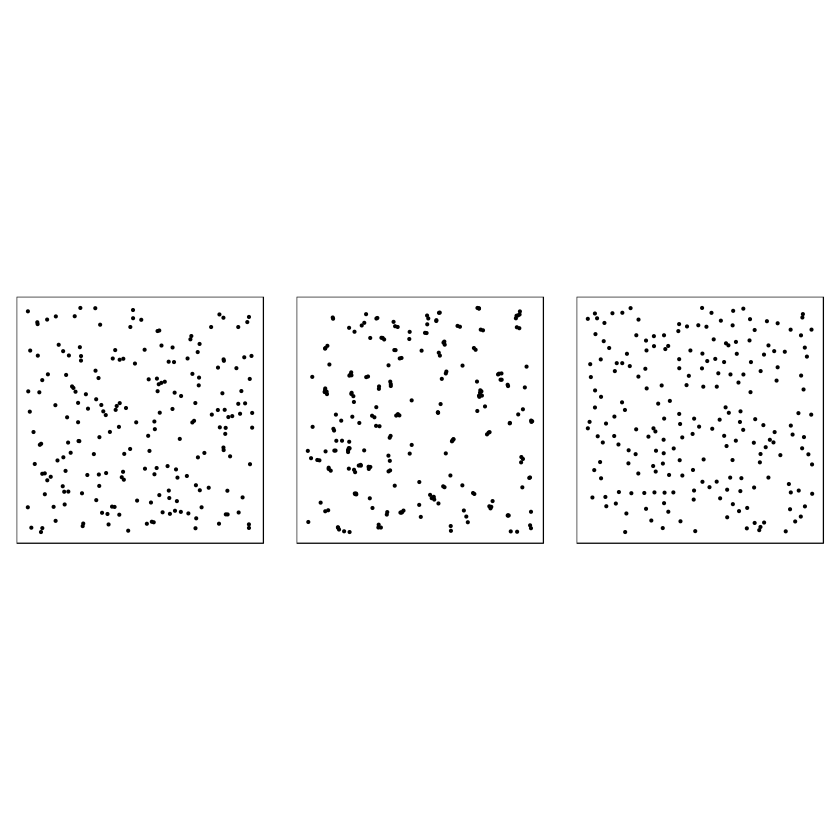

In [9]:
pps <- list(ppps_val[[1]], mcps[[1]], strs[[1]])
plots <- lapply(pps, 
                function(pp) qplot(x = pp$x, 
                                   y = pp$y, 
                                   size = I(.5)) + 
                    theme_void() +
                    theme(plot.margin = margin(10, 10, 10, 10)) +
                    theme(panel.border = element_rect(fill = NA)) 
                )
grid.arrange(plots[[1]], plots[[2]], plots[[3]], 
             nrow = 3, ncol = 3)

Next, we compare the persistence diagrams.

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

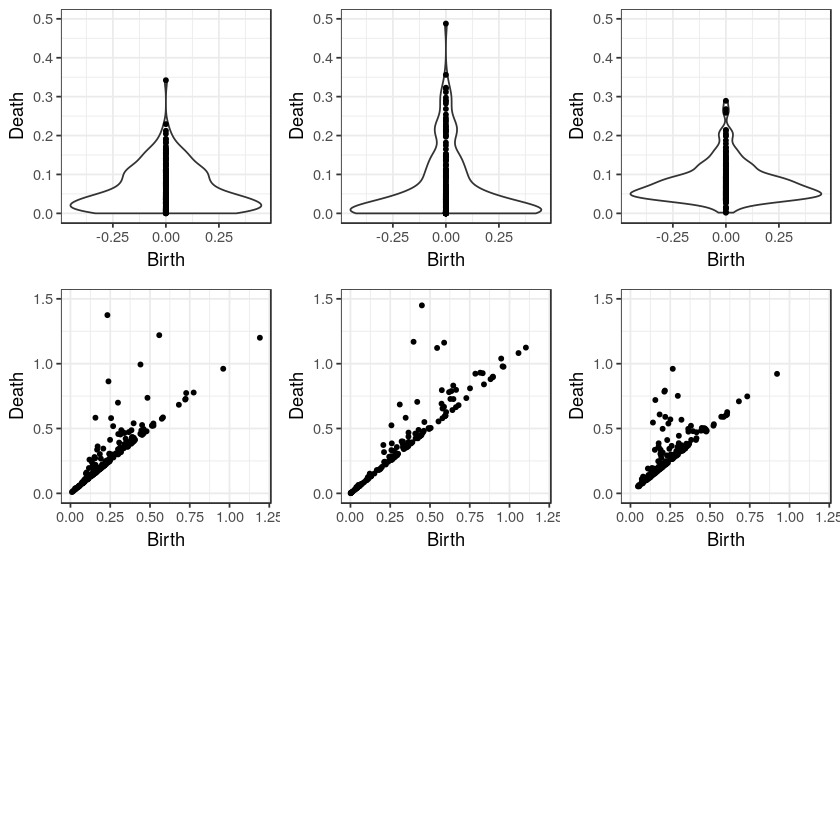

In [20]:
library(grid)
real <- 9

plots0 <- lapply(list(ppps_val[[real]], mcps[[real]],  strs[[real]]), 
                function(pp){
                    pd <- alphaComplexDiag(cbind(pp$x, pp$y))$diag
                            ggplot(data.frame(pd[pd[,'dimension'] == 0, 
                                                 2:3][-1,]), 
                            aes(x = Birth, y = Death)) +
                            geom_violin() +
                            geom_point(size = 1) +
                            scale_y_continuous(limits = c(0, 0.5)) +
                            theme_bw()                           
                    })

plots1 <- lapply(list(ppps_val[[real]],mcps[[real]], strs[[real]]), 
                function(pp){
                    pd <- alphaComplexDiag(cbind(pp$x, pp$y))$diag
                            ggplot(data.frame(pd[pd[,'dimension'] == 1, 2:3]), 
                            aes(x = Birth, y = Death)) +
                            geom_point(size = 1) +
                            scale_x_continuous(limits = c(0, 1.2)) + 
                            scale_y_continuous(limits = c(0, 1.5)) +
                            theme_bw()
                    })
grid.arrange(grobs = list(plots0[[1]], plots0[[2]], plots0[[3]],
                           plots1[[1]] ,plots1[[2]],plots1[[3]]),
            ncol = 3, nrow = 3)

### Means and Variances of Test Statistics under the Null Model

Now, we determine the means and variances of the test statistics under the null model. For this purpose, we compute the death times and accumulated life times for 10,000 independent draws of a Poisson point process.

In [21]:
seed <- 42
set.seed(seed)
nsim <- 1e4

ppps <- rpoispp(2, win = win, nsim = nsim)

It is convenient to organize both the functional summary statistics in data frames.

In [24]:
tda_df <- function(pps, stat){
    #' return statistic in data frame
    #'
    #' @param pps point processes for statistics are computed
    #' @param stat summary statistic
    tda_list <- mclapply(pps,
                stat,
                mc.cores = 4
               )
    do.call('rbind', lapply(tda_list, function(dt) dt$iso))
}

In [23]:
ppps_tda0_df <- tda_df(ppps, tda0)
ppps_tda1_df <- tda_df(ppps, tda1)      

Now, we compute the means and variances for the two statistics. For the loops, we can choose the entire relevant range of radii, so that $t_{\mathsf L} = 0.5$. For the clusters, it would be unreasonable, as for large values of the radius, we simply obtain the number of points in the observation window, which is not discriminative. Hence, we choose a smaller bound $t_{\mathsf C} = 0.1$.

In [25]:
null_mean0 <- mean(ppps_tda0_df[, 1:100])
null_sd0 <- sd(rowMeans(ppps_tda0_df[, 1:100]))

null_mean1 <- mean(ppps_tda1_df)
null_sd1 <- sd(rowMeans(ppps_tda1_df))

### Test errors of Type I & II

Since the test statistics is asymptotically normal, knowledge of means and variances under the null model allows us to assess the test errors of type I and II.

In [26]:
p_val <- function(pp, null_mean, null_sd, idx_max=100){
    #' p-value for deviation test
    #'
    #' @param pp point pattern to be tested
    #' @param null_mean mean under the null model
    #' @param null_sd standard deviation under the null model
    #' @param ind_max maximal index for integration
    z_val <- abs(mean(tda0(pp)$iso[1:idx_max]) - null_mean) / null_sd
    2 * (1 - pnorm(z_val))
}

To validate the type I error, we draw 1,000 new realizations of the null model. In order to assess the type II error, we also generate the Matérn cluster and the Strauss process for attractive and repulsive alternatives, respectively. The intensity parameter $\beta$ of the Strauss process was tuned to match approximately the intensity of the null model.

 We then compute, how often the test statistics falls outside the asymptotic 95% confidence interval. We obtain a type I error of 5.1%, which is close to the nominal 5% level. Using the mean and standard deviation from the null model, we now compute the type II errors. For the Matérn and Strauss case, they equal 59.3% and 60.7%, respectively. 

In [27]:
alpha <- .05
sapply(list(ppps_val, mcps, strs),
    function(pp_list) sum(
                        mclapply(pp_list, 
                         function(pp) p_val(pp, null_mean0, null_sd0),
                         mc.cores = 4
                        ) < alpha) 
                      )

[1]  51 593 607

When considering the loop-based test-statistic, we obtain a type I error of 4.8%, so that the confidence level is kept. Moreover, the power analysis reveals that it is substantially better in detecting deviations from the null hypothesis than just relying on the 0-dimensional features. For the Matérn cluster and Strauss processes the powers are 94.7% and 71.4%, respectively.

In [28]:
sapply(list(ppps_val, mcps, strs),
    function(pp_list) sum(
                        mclapply(pp_list, 
                         function(pp) p_val(pp, null_mean1, null_sd1),
                         mc.cores = 4
                        ) < alpha) 
                      )

[1] 1000 1000 1000

### Visualization

Finally, we visualize the average value of the statistics for the considered point processes.

The mean curves for the death times of clusters match up with the intuition about clustering and repulsion. For large radii, they all approach a common value, namely the expected number of points in the observation window. However, for the Matérn model, the slope is far steeper for small distances, caused by the merging of components of points within clusters. In contrast, for the Strauss process the slope is at first much smaller than in the Poisson model, thereby reflecting the repulsive nature of the Gibbs potential.

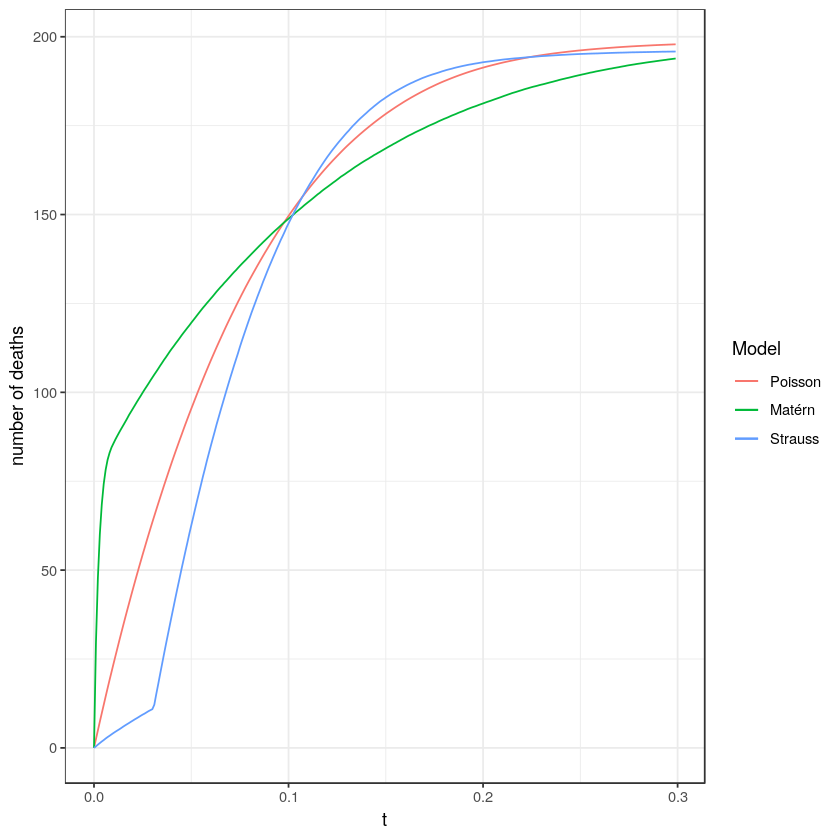

In [29]:
compare_df <- data.frame(
  t = t_vals0,
  ppp = colMeans(ppps_tda0_df),
  mcp = colMeans(tda_df(mcps, tda0)),
  str = colMeans(tda_df(strs, tda0))
)

ggplot(compare_df, aes(t)) +
  geom_line(aes(y = ppp, color = "a")) +
  geom_line(aes(y = mcp, color = "b")) +
  geom_line(aes(y = str, color = "c")) +
  scale_color_discrete(name = "Model", 
                       labels = c("Poisson", "Matérn", "Strauss")) +
  xlab('t') +
  ylab('number of deaths') + 
  theme_bw()

When comparing the shapes for the loop-based features, a radically different picture emerges. Here, the APF for the repulsive Strauss process lies above the accumulated life times of the null model. Although the average lifetime of the features in the Strauss process is smaller than in the Poisson model, there are substantially more births. Taken together, these competing effects still lead to a net increase of the accumulated life times in the Strauss model compared to the Poisson setting. 

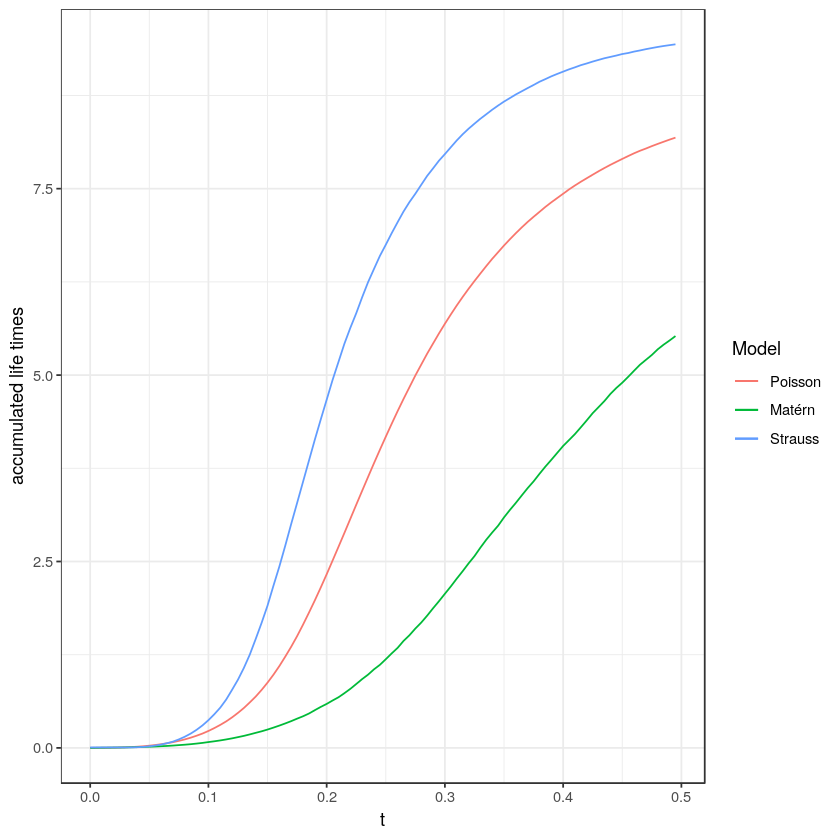

In [30]:
compare_df <- data.frame(
    t = t_vals1,
    ppp = colMeans(ppps_tda1_df),
    mcp = colMeans(tda_df(mcps, tda1)),
    str = colMeans(tda_df(strs, tda1))
)

ggplot(compare_df, aes(t)) +
    geom_line(aes(y = ppp, color = "a")) +
    geom_line(aes(y = mcp, color = "b")) +
    geom_line(aes(y = str, color = "c")) +
    scale_color_discrete(name = "Model", 
                         labels = c("Poisson", "Matérn", "Strauss")) +
    xlab('t') +
    ylab('accumulated life times') + 
    theme_bw()

Finally, we provide a surface plot of the persistent Betti numbers. More precisely, the value at a coordinate $(x, y)$ corresponds to the number of features born before time $x$ and living longer than $y$. The two-dimensional plot supports the previous observation.

In [120]:
tda1_surf_plot <-function(pps){
    #' Surface plot of averaged persistent betti number for a list of point patterns
    #'
    #' @param pps list of point patterns
    bns <- lapply(pps, tda1_2d)

    #average over simulations
    lts <- lapply(bns, function(bn) melt(bn)[,3])
    lts_avg <- colMeans(do.call("rbind", lts))

    tx <- as.numeric(rownames(bns[[1]]))
    ty <- as.numeric(colnames(bns[[1]]))
    persp3D(matrix(lts_avg, nrow=length(tx)), 
            x = tx, 
            y = ty,  
            phi = 10, 
            theta = -130 ,
            ticktype = "detailed", 
            bty = "b2",
            colkey = F, 
            nticks=3)   
}

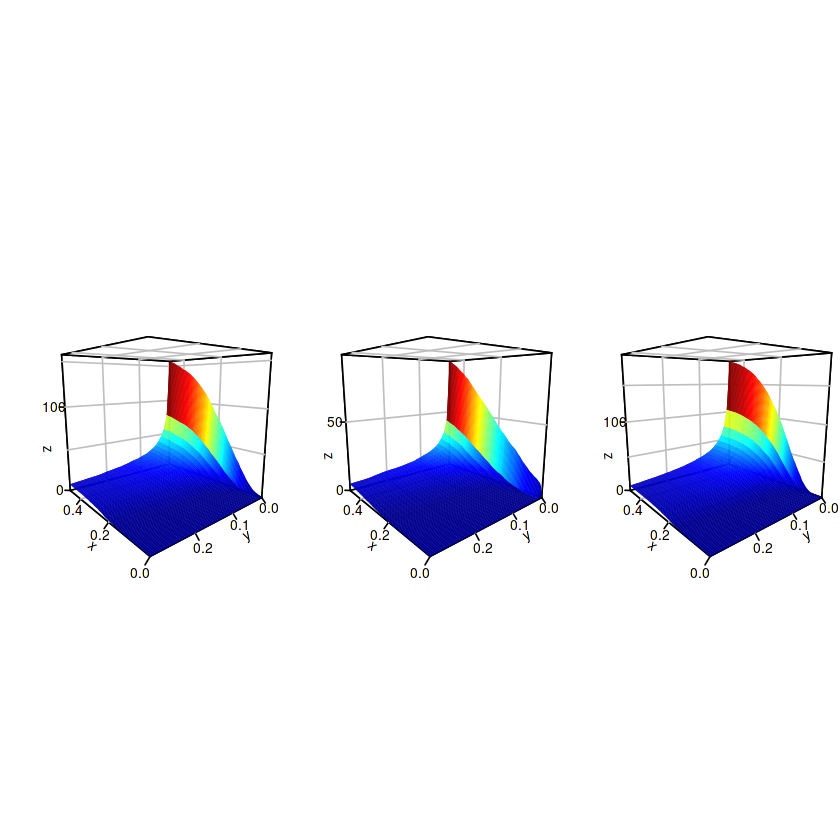

In [140]:
par(mfrow=c(1,3))
par(mar=c(0, 3.2, 3.2, .0))
tda1_surf_plot(ppps[1:20])
tda1_surf_plot(mcps[1:20])
tda1_surf_plot(strs[1:20])

## Envelope Tests for Complete Spatial Randomness

Leveraging the functional CLT allowed us to deduce that the deviation statistics considered above is asymptotically normal. Hence, we could easily extract an estimate for the asymptotic variance under the null model via simulation.  A caveat of the above analysis is that the clustering and repulsion effects were very strong.

Recently, [global rank-envelope tests](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/rssb.12172) are becoming widely adopted, as they are both powerful and provide additional information as to why a null hypothesis is rejected. The global rank envelope tests are fundamentally Monte Carlo-based tests and therefore do not relate directly to the functional CLT. However, they also rely on a functional summary statistics as input. In most of the application cases in spatial statistics, one of the distance-based second-order functionals such as Ripley's K-function or L-function are used. In this section, we analyze the effect of replacing them by TDA-based statistics. 

Since envelope tests are typically able to detect very subtle changes from the null model, we consider now a parameter set-up, where both the Matérn cluster as well as the Strauss process are substantially more similar to the Poisson point process.

As a first step, we generate $s = 4,999$ realizations of the null model.

In [149]:
seed <- 43
set.seed(seed)

s <- 5e3 - 1

ppps_env <- rpoispp(2, win=win, nsim=s)

Next, we generate 1,000 realizations of the alternatives, where we use again Matérn cluster and Strauss processes. However, we use different parameters when investigating the power of statistics related to features in dimension 0 and 1. 

We found that the TDA-based-tests based on the 0-dimensional statistics were particularly powerful in situations involving small interaction radii. Hence, for the Matérn cluster process, we consider a parent process of intensity $20$ and put a $\mathsf{Poi}(.1)$-distributed number of children in disks of radius $0.1$ around the parent points. The interaction parameter and interaction radius of the Strauss process are given by $\gamma = 0.1$ and $r=0.1$, respectively. The intensity parameter $\beta = 2.1$ is chosen so as to match up approximately with the intensity of the null model.

In [29]:
seed <- 45
set.seed(seed)
npowtest <- 1e3

mcps_env <- rMatClust(20, .1, .1, win=win, nsim=npowtest)
strs_env <- rStrauss(2.1, .1, .1, W=win, nsim=npowtest)

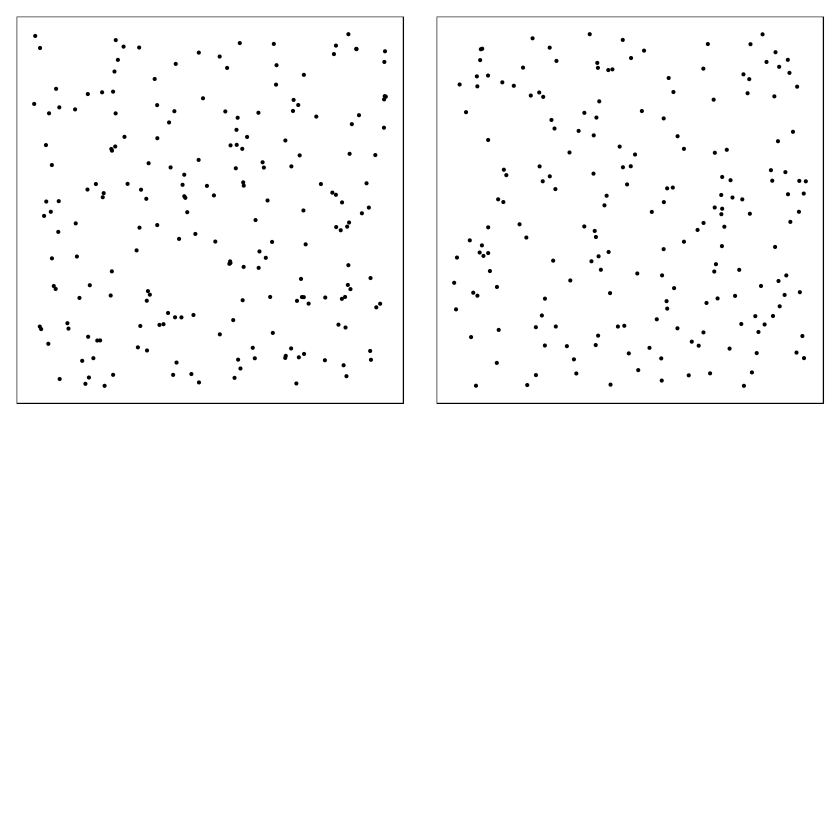

In [30]:
pps <- list(mcps_env[[1]], strs_env[[1]])
plots <- lapply(pps,
                function(pp)
                    qplot(pp$x, 
                          y = pp$y, 
                          size = I(.5)) + 
                    xlab(label = 'x') +
                    ylab(label = 'y') + 
                    theme_void() +
                    theme(plot.margin = margin(10,10,10,10)) +
                    theme(panel.border = element_rect(fill=NA)) 
               ) 

require(gridExtra)
grid.arrange(plots[[1]], plots[[2]], nrow=2, ncol=2)

### Envelope Tests based on Ripley's L-Function

Before performing the envelope tests via TDA, we first see how well they perform when using Ripley's L-function as summary statistics.

In [108]:
L_env <- lapply(list(ppps_env, mcps0_env, strs0_env, mcps1_env, strs1_env),
                        function(pp_list)
                            mclapply(unname(pp_list),
                                    Lest,
                                    mc.cores=4
                           )
                       )

To be compatible with the GET package, the list of death times must be converted into a curve set data structure.

In [17]:
dts2curves <- function(observed, nulls){
    #' Convert an observed curve and null curves into a curve set
    #'
    #' @param observed curve for an observed point pattern
    #' @param nulls list of curves for a null model
    curve_set <-do.call('cbind', lapply(nulls, function(dt) dt$iso))
    curve_set <- cbind(observed, curve_set)    
    curve_set <- as.matrix(curve_set)
    create_curve_set(list(r=nulls[[1]]$r, obs=curve_set))
}

In [111]:
L_curves <- lapply(L_env[2:5], 
                   function(pp_list) 
                        mclapply(unname(pp_list), 
                                function(dt) dts2curves(dt$iso, L_env[[1]]),
                                mc.cores=4)
                   )

Now, we extract the p-values from the global envelope test. We see that we obtain a power of 42.6% and 20.5% for the Matérn and Strauss data.

In [112]:
L_ps = lapply(L_curves,
              function(curve_list)
                  unlist(mclapply(curve_list, 
                    function(curve) attr(global_envelope_test(curve), "p"),
                    mc.cores=4))
              )

In [2]:
alpha <- .05
sapply(L_ps[1:2], function(p_list) sum(p_list < alpha))


[1] 426 205

### Envelope Tests based on Death Times

Next, we repeat the analysis with the L-function replaced by the death times.

In [13]:
tda0_env <- lapply(list(ppps_env, mcps_env, strs_env),
                        function(pp_list)
                            mclapply(unname(pp_list),
                            tda0,
                            mc.cores=10
                           )
                       )
saveRDS(tda0_env, "tda0_env.rds")

Hence, we convert the envelopes to the curve data structure.

In [19]:
tda0_curves <- lapply(tda0_env[2:3], 
                      function(env) mclapply(env,
                                             function(dt) dts2curves(dt$iso, tda0_env[[1]]),
                                             mc.cores=10)
                      )


Now, we extract the p-values from the global envelope test and recover a power of 41.5% and 26.3% for the Matérn and Strauss data, respectively. 

In [163]:
tda0_ps = lapply(tda0_curves,
              function(curve_list)
                  unlist(mclapply(curve_list, 
                    function(curve) attr(global_envelope_test(curve), "p"),
                    mc.cores=10))
              )
sapply(tda0_ps, function(p_list) sum(p_list < alpha))

[1] 415 263

### Two-Dimensional Envelope Test

Finally, we perform the envelope tests based on the 1-dimensional features. Since the 1-dimensional features have both a non-trivial birth time and a non-trivial life time, we consider the envelope test for surfaces.

First, we compute the birth times together with the associated life times for the null model.

In [157]:
ppp_bns <-  mclapply(ppps_env, 
                     tda1_2d,
                    mc.cores=4)
sims <- array(as.numeric(unlist(ppp_bns)), dim=c(100, 30, length(ppps_env)))
sims <- aperm(sims, c(3, 1, 2))

Time difference of 2.040242 mins

Then, we do the same for the alternatives.

In [159]:
alt_bns <- lapply(list(mcps_env, strs_env),
                 function(pps) mclapply(pps,
                                        tda1_2d,
                                        mc.cores=4)
                  )

Based on these curves, we extract the  perform the global envelope test.  We recover a power of 27.0% and 32.2% for the Matérn and Strauss data, respectively. Hence, considering the surface-envelope for the 1-dimensional features gives even better a better power for the Strauss data than using the one-dimensional features. Both tests significantly outperform the L-function-based test. Conversely, in the clustered case the 1-dimensional features lead to a less powerful test.


In [161]:
bn_ps <- lapply(alt_bns,
                function(bns)
                    mclapply(bns,
                            function(bn) attr(global_envelope_test_2d(bn, sim = sims, rx=t_vals1,ry=ty1), "p"),
                             mc.cores=4)
                )

sapply(bn_ps,
       function(ps)
           sum(unlist(ps)<alpha)
        )